<a href="https://colab.research.google.com/github/ShaheryarRafique/machine-learning/blob/main/KNN_sentiment_analysis_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from collections import Counter
import re
import string

In [ ]:
with open("sample_data/stop_words.txt", 'r') as file:
  stop_words = file.read().splitlines()

In [ ]:
data = pd.read_csv("sample_data/apple_sentiment_tweets.csv")

In [ ]:
# Function to clean the text
def clean_text(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
  text = text.translate(str.maketrans('', '', string.punctuation))
  text_tokens = text.split()
  text = ' '.join([word for word in text_tokens if word not in stop_words and len(word) > 1])
  return text

In [ ]:
# Step 3: Text preprocessing
data['cleaned_text'] = data['text'].apply(clean_text)

In [ ]:
# Step 4: Train-test split (80-20)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Create vocabulary from training data only
train_words = ' '.join(train_data['cleaned_text']).split()
vocabulary = list(set(train_words))
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

In [ ]:
 # Convert text to BoW vectors
def create_bow(data):
    bow_vectors = []
    for text in data['cleaned_text']:
        vector = np.zeros(len(vocabulary), dtype=np.float64)
        for word in text.split():
            if word in word_to_index:
                vector[word_to_index[word]] += 1
        bow_vectors.append(vector)

    return np.array(bow_vectors)

In [ ]:
# Step 5: Create Bag-of-Words representation
X_train = create_bow(train_data)
X_test = create_bow(test_data)
y_train = train_data['sentiment'].values
y_test = test_data['sentiment'].values

In [ ]:
# Step 6: k-NN implementation with scikit-learn
k_values = list(range(1, 11))
distance_metrics = ['euclidean', 'manhattan']
cv_results = {metric: {'accuracy': [], 'f1': []} for metric in distance_metrics}

In [ ]:
for metric in distance_metrics:
    print(f"\n=== Evaluating {metric} distance ===")
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

        # 5-fold cross-validation
        acc_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        f1_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')

        cv_results[metric]['accuracy'].append(np.mean(acc_scores))
        cv_results[metric]['f1'].append(np.mean(f1_scores))

        print(f"k={k}: Accuracy={np.mean(acc_scores):.3f}, F1={np.mean(f1_scores):.3f}")


=== Evaluating euclidean distance ===
k=1: Accuracy=0.619, F1=0.491
k=2: Accuracy=0.600, F1=0.456
k=3: Accuracy=0.587, F1=0.419
k=4: Accuracy=0.614, F1=0.433
k=5: Accuracy=0.583, F1=0.395
k=6: Accuracy=0.600, F1=0.414
k=7: Accuracy=0.593, F1=0.397
k=8: Accuracy=0.616, F1=0.413
k=9: Accuracy=0.599, F1=0.385
k=10: Accuracy=0.619, F1=0.435

=== Evaluating manhattan distance ===
k=1: Accuracy=0.615, F1=0.487
k=2: Accuracy=0.590, F1=0.444
k=3: Accuracy=0.581, F1=0.411
k=4: Accuracy=0.604, F1=0.422
k=5: Accuracy=0.575, F1=0.385
k=6: Accuracy=0.595, F1=0.411
k=7: Accuracy=0.587, F1=0.392
k=8: Accuracy=0.613, F1=0.410
k=9: Accuracy=0.597, F1=0.383
k=10: Accuracy=0.612, F1=0.425


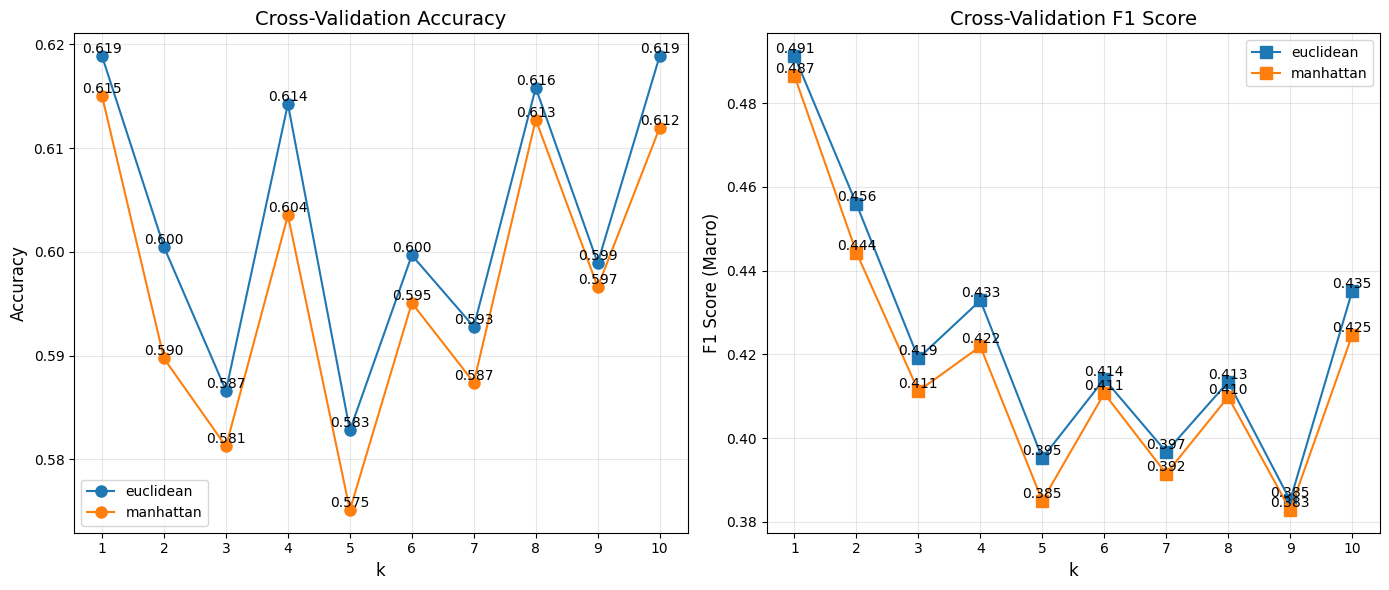

In [ ]:
# Step 7: Plot results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for metric in distance_metrics:
    plt.plot(k_values, cv_results[metric]['accuracy'], 'o-', label=metric, markersize=8)
    for k, acc in zip(k_values, cv_results[metric]['accuracy']):
        plt.text(k, acc, f'{acc:.3f}', ha='center', va='bottom')
plt.xlabel('k', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-Validation Accuracy', fontsize=14)
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
for metric in distance_metrics:
    plt.plot(k_values, cv_results[metric]['f1'], 's-', label=metric, markersize=8)
    for k, f1 in zip(k_values, cv_results[metric]['f1']):
        plt.text(k, f1, f'{f1:.3f}', ha='center', va='bottom')
plt.xlabel('k', fontsize=12)
plt.ylabel('F1 Score (Macro)', fontsize=12)
plt.title('Cross-Validation F1 Score', fontsize=14)
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
 # Step 8: Find best k for each metric
best_k = {}
for metric in distance_metrics:
    best_idx = np.argmax(cv_results[metric]['f1'])
    best_k[metric] = k_values[best_idx]
    print(f"\nBest for {metric}: k={best_k[metric]} with F1={cv_results[metric]['f1'][best_idx]:.3f}")


Best for euclidean: k=1 with F1=0.491

Best for manhattan: k=1 with F1=0.487


In [ ]:
# Step 9: Final evaluation on test set
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print("\nAccuracy:", accuracy_score(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))

print("\n=== Final Test Evaluation ===")
for metric in distance_metrics:
    knn = KNeighborsClassifier(n_neighbors=best_k[metric], metric=metric)
    knn.fit(X_train, y_train)

    print(f"\nResults for {metric} (k={best_k[metric]}):")
    evaluate_model(knn, X_test, y_test)


=== Final Test Evaluation ===

Results for euclidean (k=1):

Accuracy: 0.6441717791411042

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.28      0.43       137
     Neutral       0.59      1.00      0.74       165
    Positive       0.70      0.29      0.41        24

    accuracy                           0.64       326
   macro avg       0.76      0.52      0.53       326
weighted avg       0.77      0.64      0.59       326


Confusion Matrix:
[[ 38  96   3]
 [  0 165   0]
 [  0  17   7]]

Results for manhattan (k=1):

Accuracy: 0.6349693251533742

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.26      0.41       137
     Neutral       0.59      1.00      0.74       165
    Positive       0.78      0.29      0.42        24

    accuracy                           0.63       326
   macro avg       0.79      0.52      0.52       326
weighted avg       0.77      